原始数据形状: (1181, 140)

====== 针对140特征 ======
去除零方差后形状: (1181, 134)
标准化后形状: (1181, 134)
HDBSCAN找到 3 个簇


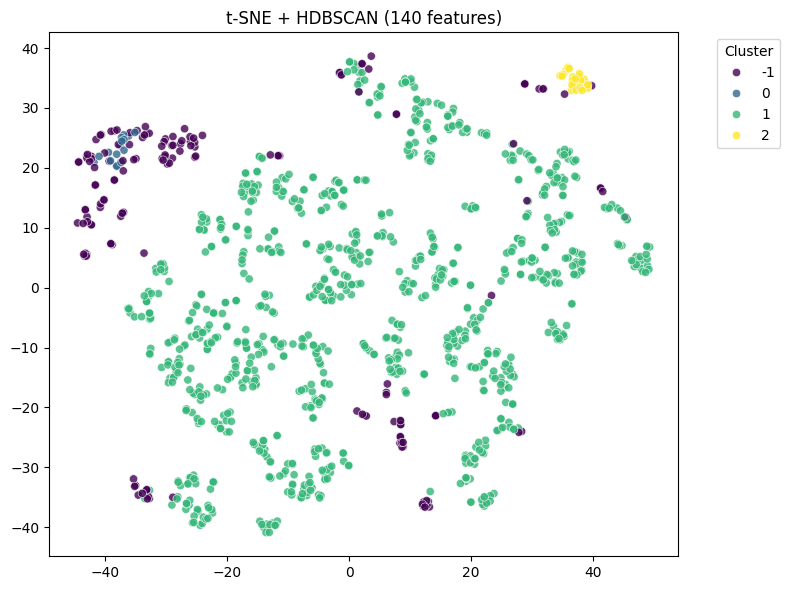

Outliers: 158 samples
Cluster 0: 17 samples
Cluster 1: 984 samples
Cluster 2: 22 samples
Density threshold for outliers: 10.999776899359182
4 clusters were extracted (excluding outliers).


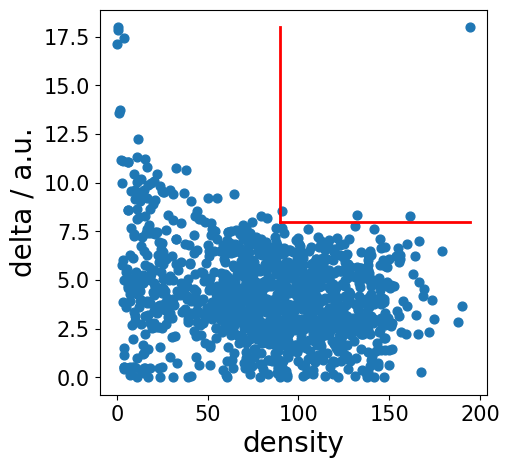

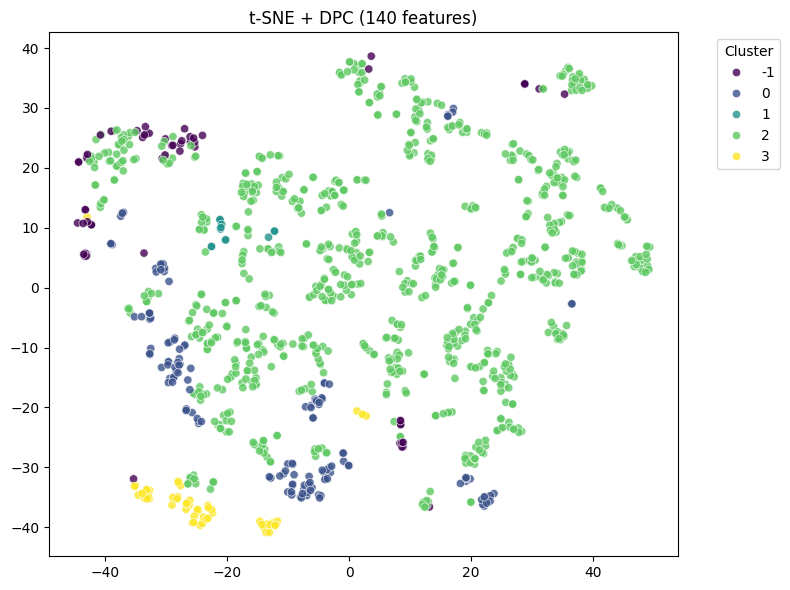

Outliers: 59 samples
Cluster 0: 143 samples
Cluster 1: 12 samples
Cluster 2: 911 samples
Cluster 3: 56 samples

====== 针对PCA 20组分 ======
PCA降维到20维后形状: (1181, 20)
HDBSCAN找到 3 个簇


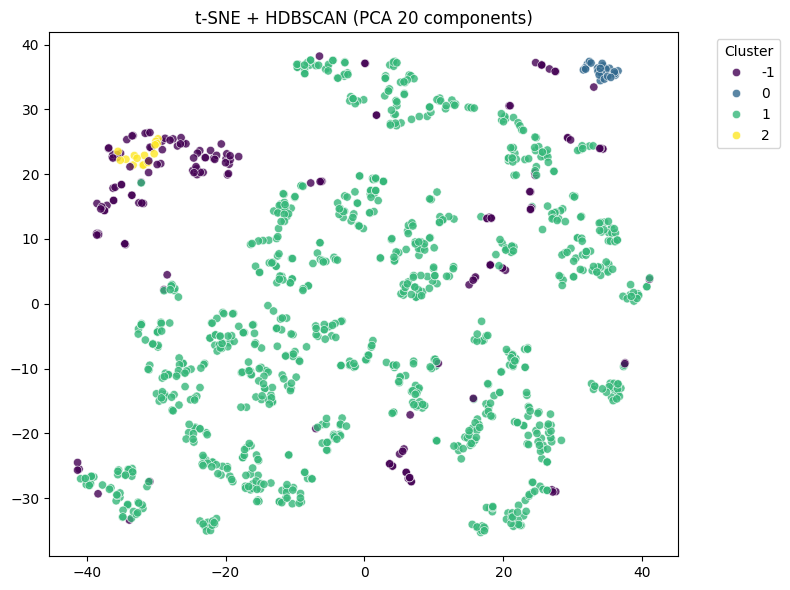

Outliers: 164 samples
Cluster 0: 23 samples
Cluster 1: 978 samples
Cluster 2: 16 samples
Density threshold for outliers: 8.635465931894661
3 clusters were extracted (excluding outliers).


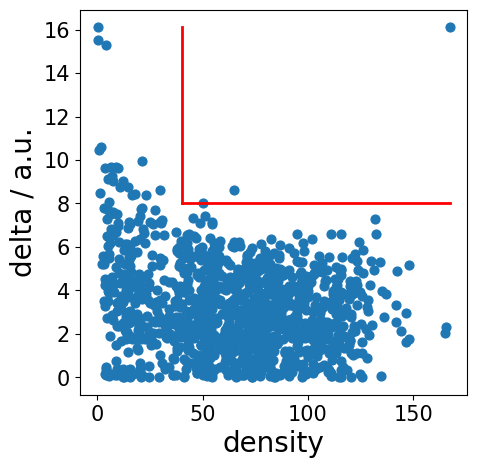

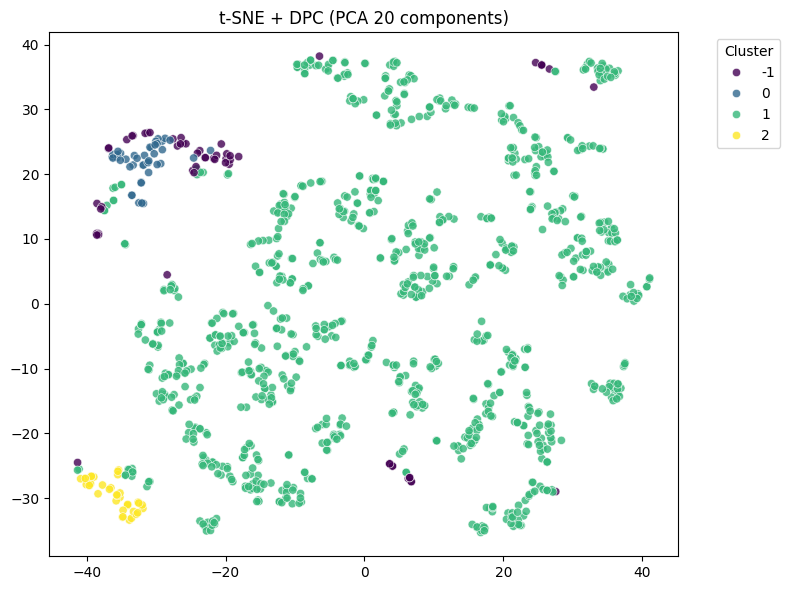

Outliers: 59 samples
Cluster 0: 43 samples
Cluster 1: 1042 samples
Cluster 2: 37 samples

===== 全部流程完成 =====


In [11]:
# ---------------------- 导入库 -----------------------------------
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import hdbscan
from pydpc import Cluster as DPCClustering
import matplotlib.pyplot as plt
import seaborn as sns

np.bool = bool  # 解决 pydpc 的 bool 问题

# ---------------------- 一、数据读取 ---------------------------------
df_raw = pd.read_csv("features-bulk.csv")
print(f"原始数据形状: {df_raw.shape}")

# ---------------------- 二、特征预处理 -------------------------------
def preprocess_features(df, feature_count='all'):
    data = df.values
    col_stds = data.std(axis=0)
    zero_std_mask = (col_stds == 0)
    data_nonzero = data[:, ~zero_std_mask]  # 去除零方差
    if feature_count == 20:
        data_nonzero = data_nonzero[:, :20]  # 取前20列
    print(f"去除零方差后形状: {data_nonzero.shape}")
    return data_nonzero

# ---------------------- 三、标准化 -----------------------------------
def standardize_data(data):
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(data)
    print(f"标准化后形状: {data_normalized.shape}")
    return data_normalized

# ---------------------- 四、PCA -------------------------------------
def run_pca(data, n_components=20):
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(data)
    print(f"PCA降维到{n_components}维后形状: {pca_data.shape}")
    return pca_data

# ---------------------- 五、HDBSCAN 聚类 ------------------------------
def hdbscan_clustering(data, min_cluster_size=6, min_samples=10):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric='euclidean')
    clusterer.fit(data)
    labels = clusterer.labels_
    print(f"HDBSCAN找到 {len(set(labels)) - (1 if -1 in labels else 0)} 个簇")
    return labels

# ---------------------- 六、DPC 聚类（保留你原版代码） ------------------------------
class MyClustering:
    def __init__(self, df, feature_array):
        """
        df:         你的 DataFrame，行数需与 feature_array 对应
        feature_array:  形如 (n_samples, 20) 的 PCA 结果数组，
                        或者标准化后的 140 个特征数据，
                        即你想用来做聚类的特征数据
        """
        self.df = df
        self.feature_array = feature_array  # 直接存数组
        self.df_flag = False        # 用来控制是否跳过聚类逻辑（可随意）
    
    def dpc(self, density=0, delta=0):
        """
        如果 density、delta 都 > 0，则根据这两个值调用 assign()，
        否则仅初始化 DPCClustering，但不执行聚类。
        最后把标签写进 self.df['cluster_label']。
        增加异常值处理逻辑：基于密度计算异常值，并标记为 -1。
        """
        # 如果 df_flag 为 True，就什么都不做
        if self.df_flag:
            return
        
        # 1. 取出特征数组，用于聚类
        X = np.ascontiguousarray(self.feature_array)
        
        # 2. 判断 density、delta
        if density > 0 and delta > 0:
            # 正式执行 DPCClustering
            clu = DPCClustering(X, autoplot=False)
            clu.autoplot = True
            
            # assign(density, delta) 进行聚类
            clu.assign(density, delta)
            
            # 获取聚类标签
            cluster_labels = clu.membership
            
            # 获取每个点的密度
            densities = clu.density
            
            # 计算密度的第 5 个百分位数作为阈值
            density_threshold = np.percentile(densities, 5)
            print(f"Density threshold for outliers: {density_threshold}")
            
            # 找到密度低于阈值的点，标记为异常值（-1）
            outlier_indices = densities < density_threshold
            cluster_labels_adjusted = cluster_labels.copy()
            cluster_labels_adjusted[outlier_indices] = -1
            
            # 输出聚类数（不包括异常值，标签从 0 开始，因此 +1）
            num_clusters = len(set(cluster_labels_adjusted)) - (1 if -1 in cluster_labels_adjusted else 0)
            print(f"{num_clusters} clusters were extracted (excluding outliers).")
            
            # 将聚类结果写回 DataFrame
            self.df["clustering"] = "DPC"
            self.df["cluster_label"] = cluster_labels_adjusted
            #self.df["density"] = densities
            
        else:
            # 未传有效的 density 和 delta，只初始化
            clu = DPCClustering(X)
            print("未指定 density 和 delta，仅初始化了 DPCClustering 对象，可后续手动 assign。")

# ---------------------- 七、t-SNE 可视化 -------------------------------
def tsne_visualization(data, labels, title):
    embedding = TSNE(n_components=2, random_state=42).fit_transform(data)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='viridis', alpha=0.8)
    plt.title(title)
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# ---------------------- 八、统计输出 ------------------------------
def print_cluster_summary(labels):
    unique, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique, counts):
        name = "Outliers" if label == -1 else f"Cluster {label}"
        print(f"{name}: {count} samples")

# ---------------------- 九、执行流程 (带独立参数) ------------------------------

# ===== 针对140特征 =====
print("\n====== 针对140特征 ======")
# 预处理 & 标准化（使用全部特征）
data_140 = preprocess_features(df_raw, feature_count='all')
data_140_norm = standardize_data(data_140)

# --- HDBSCAN (140特征) ---
labels_140_hdbscan = hdbscan_clustering(data_140_norm, min_cluster_size=7, min_samples=11)
tsne_visualization(data_140_norm, labels_140_hdbscan, "t-SNE + HDBSCAN (140 features)")
print_cluster_summary(labels_140_hdbscan)

# --- DPC (140特征) ---
# 此处使用标准化后的 140 个特征数据
df_140_dpc = df_raw.copy()
my_clu_140 = MyClustering(df_140_dpc, data_140_norm)
my_clu_140.dpc(density=90, delta=8)
tsne_visualization(data_140_norm, df_140_dpc['cluster_label'], "t-SNE + DPC (140 features)")
print_cluster_summary(df_140_dpc['cluster_label'])

# ===== 针对 PCA-20组分 单独聚类 =====
print("\n====== 针对PCA 20组分 ======")

# --- PCA 提取20组分 ---
pca_20_data = run_pca(data_140_norm, n_components=20)

# --- HDBSCAN (PCA-20组分) ---
labels_20_hdbscan = hdbscan_clustering(pca_20_data, min_cluster_size=6, min_samples=10)
tsne_visualization(pca_20_data, labels_20_hdbscan, "t-SNE + HDBSCAN (PCA 20 components)")
print_cluster_summary(labels_20_hdbscan)

# --- DPC (PCA-20组分) ---
df_20_dpc = df_raw.copy()
my_clu_20 = MyClustering(df_20_dpc, pca_20_data)
my_clu_20.dpc(density=40, delta=8)
tsne_visualization(pca_20_data, df_20_dpc['cluster_label'], "t-SNE + DPC (PCA 20 components)")
print_cluster_summary(df_20_dpc['cluster_label'])

# ---------------------- 十、总结 ------------------------------
print("\n===== 全部流程完成 =====")


In [31]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from sklearn.manifold import TSNE

# -------------------- Plotly 在 Notebook 中的渲染器设置 --------------------
pio.renderers.default = "notebook_connected"

# -------------------- 1. 函数：给 DataFrame 添加 t-SNE 坐标 --------------------
def add_tsne_embedding(df, feature_data, random_state=42):
    """
    对 feature_data (numpy 数组) 做 t-SNE 降维，并将结果写入 df 的 'x_emb', 'y_emb' 列中。
    """
    tsne = TSNE(n_components=2, random_state=random_state)
    embedding = tsne.fit_transform(feature_data)
    df["x_emb"] = embedding[:, 0]
    df["y_emb"] = embedding[:, 1]
    return df

# -------------------- 2. 函数：Plotly 交互式散点图 --------------------


def plot_interactive(df, color_feature, custom_title, hover_features=["space_group", "density", "K_VRH"]):
    """
    使用 Plotly 生成交互式散点图：
      - x_emb, y_emb 作为坐标
      - color_feature 用于着色（支持 cluster_label, density, space_group, K_VRH）
      - hover_features 中的列在鼠标悬停时显示
      - custom_title 作为图标题
    """
    # 确保 color_feature 在 DataFrame 中
    if color_feature not in df.columns:
        raise ValueError(f"Column '{color_feature}' not found in DataFrame!")

    # 若按聚类标签着色，则转换为字符串
    if color_feature == "cluster_label":
        df[color_feature] = df[color_feature].astype(str)
    
    # 判断是离散变量（categorical）还是连续变量（numerical）
    is_discrete = df[color_feature].dtype == object

    fig = px.scatter(
        df,
        x="x_emb",
        y="y_emb",
        color=color_feature,
        title=custom_title,
        labels={"x_emb": "t-SNE Dim 1", "y_emb": "t-SNE Dim 2"},
        color_discrete_sequence=px.colors.qualitative.Vivid if is_discrete else None,  # 离散数据（如 cluster_label）
        color_continuous_scale="Turbo" if not is_discrete else None,  # 连续数据（如 density, K_VRH）
        hover_data=hover_features,
        opacity=0.8
    )

    # 设定散点大小
    fig.update_traces(marker=dict(size=8))

    # 调整布局
    fig.update_layout(
        legend_title=dict(text=color_feature),
        legend=dict(orientation="v", x=1.02, y=1, bgcolor="rgba(255,255,255,0.5)"),
        margin=dict(l=50, r=10, t=50, b=10),
        width=1000,
        height=600
    )
    # 设定散点大小和边框
    fig.update_traces(
        marker=dict(size=8,  # 增大点的大小
                    line=dict(width=0.8, color="white")),  # 给每个点加边框
    )
# 调整颜色条的样式
    fig.update_layout(
        coloraxis_colorbar=dict(
            title=color_feature,  # 颜色条标题
            ticks="outside",  # 刻度在外
            len=0.8,  # 颜色条长度
            thickness=20,  # 颜色条宽度
            x=1.02,  # 颜色条靠右
            y=0.5  # 颜色条垂直居中
        ),
        legend_title=dict(text=color_feature),
        legend=dict(orientation="v", x=1.02, y=1, bgcolor="rgba(255,255,255,0.5)"),
        margin=dict(l=50, r=10, t=50, b=10),
        width=1000,
        height=600
    )

    fig.show()

# -------------------- 3. 构造四个 DataFrame (HDBSCAN / DPC, 140 / 20) --------------------
# 假设以下变量均已存在：
# df_raw: 原始 DataFrame，含 "space_group" 和 "density" 列
# data_140_norm: 标准化后的 140 特征数据 (numpy 数组)
# pca_20_data: PCA 降维后的 20 维数据 (numpy 数组)
# labels_140_hdbscan: 140 特征 HDBSCAN 聚类标签
# df_140_dpc: 经过 DPC 聚类（140 特征）的 DataFrame（含 "cluster_label" 和 "density" 列）
# labels_20_hdbscan: 20 组分 HDBSCAN 聚类标签
# df_20_dpc: 经过 DPC 聚类（20 组分）的 DataFrame（含 "cluster_label" 和 "density" 列）
df_bulk = pd.read_csv("target-bulk.csv") 
## (A) 140-HDBSCAN
df_140_hdbscan = df_raw.copy()
df_140_hdbscan["cluster_label"] = labels_140_hdbscan
# 保留原始 density 信息
df_140_hdbscan["density"] = df_raw["density"]
df_140_hdbscan = add_tsne_embedding(df_140_hdbscan, data_140_norm)
df_140_hdbscan["K_VRH"] = df_bulk["K_VRH"]
## (B) 140-DPC
# df_140_dpc 已含 cluster_label 和 density（DPC 聚类结果）
df_140_dpc = add_tsne_embedding(df_140_dpc, data_140_norm)
df_140_dpc["K_VRH"] = df_bulk["K_VRH"]
## (C) 20-HDBSCAN
df_20_hdbscan = df_raw.copy()
df_20_hdbscan["cluster_label"] = labels_20_hdbscan
df_20_hdbscan["density"] = df_raw["density"]
df_20_hdbscan = add_tsne_embedding(df_20_hdbscan, pca_20_data)
df_20_hdbscan["K_VRH"] = df_bulk["K_VRH"]
## (D) 20-DPC
df_20_dpc = add_tsne_embedding(df_20_dpc, pca_20_data)
 # <<< 新增
df_20_dpc["K_VRH"] = df_bulk["K_VRH"]
# -------------------- 4. 分别绘制 12 张图 --------------------
# (1) 140-HDBSCAN
plot_interactive(df_140_hdbscan, "cluster_label", "140-HDBSCAN t-SNE (Cluster Label)")
plot_interactive(df_140_hdbscan, "space_group",   "140-HDBSCAN t-SNE (Space Group)")
plot_interactive(df_140_hdbscan, "density",       "140-HDBSCAN t-SNE (Density)")
plot_interactive(df_140_hdbscan, "K_VRH",         "140_HDBSCAN t-SNE (K_VRH)")  


/Users/meiyan/miniconda3/lib/python3.9/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [21]:
# (2) 140-DPC
plot_interactive(df_140_dpc, "cluster_label", "140-DPC t-SNE (Cluster Label)")
plot_interactive(df_140_dpc, "space_group",   "140-DPC t-SNE (Space Group)")
plot_interactive(df_140_dpc, "density",       "140-DPC t-SNE (Density)")
plot_interactive(df_140_dpc, "K_VRH",         "140_DPC t-SNE (K_VRH)")  

/Users/meiyan/miniconda3/lib/python3.9/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [33]:
# (3) 20-HDBSCAN
plot_interactive(df_20_hdbscan, "cluster_label", "20-HDBSCAN t-SNE (Cluster Label)")
plot_interactive(df_20_hdbscan, "space_group",   "20-HDBSCAN t-SNE (Space Group)")
plot_interactive(df_20_hdbscan, "density",       "20-HDBSCAN t-SNE (Density)")
plot_interactive(df_20_hdbscan, "K_VRH",         "20_HDBSCAN t-SNE (K_VRH)")  

/Users/meiyan/miniconda3/lib/python3.9/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [23]:
# (4) 20-DPC
plot_interactive(df_20_dpc, "cluster_label", "20-DPC t-SNE (Cluster Label)")
plot_interactive(df_20_dpc, "space_group",   "20-DPC t-SNE (Space Group)")
plot_interactive(df_20_dpc, "density",       "20-DPC t-SNE (Density)")
plot_interactive(df_20_dpc, "K_VRH",         "20-DPC t-SNE (K_VRH)")  

/Users/meiyan/miniconda3/lib/python3.9/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

